**OrderBook Feature Engineering and Mid-Price Prediction Using LightGBM**

In [ ]:
import os
import math
from datetime import timedelta


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler


# LightGBM model
import lightgbm as lgb


# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/Copy of Data.txt")

In [ ]:
data.shape

(9999999, 33)

In [ ]:
data.head(5)

,TimeStamp,BidPrice1,BidQty1,BidNumOrders1,BidPrice2,BidQty2,BidNumOrders2,BidPrice3,BidQty3,BidNumOrders3,...,AskQty3,AskNumOrders3,AskPrice4,AskQty4,AskNumOrders4,AskPrice5,AskQty5,AskNumOrders5,LTP,LTQ
0,1434618900024502469,5,150,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1434618900025460643,10025,300,1,5,150,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1434618900026630417,10025,300,1,9195,900,1,5,150,1,...,0,0,0,0,0,0,0,0,0,0
3,1434618900027208661,10025,300,1,9195,900,1,5,150,1,...,0,0,0,0,0,0,0,0,0,0
4,1434618900027843904,10025,300,1,9195,900,1,5,150,1,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
data.columns

Index(['TimeStamp', 'BidPrice1', 'BidQty1', 'BidNumOrders1', 'BidPrice2',
       'BidQty2', 'BidNumOrders2', 'BidPrice3', 'BidQty3', 'BidNumOrders3',
       'BidPrice4', 'BidQty4', 'BidNumOrders4', 'BidPrice5', 'BidQty5',
       'BidNumOrders5', 'AskPrice1', 'AskQty1', 'AskNumOrders1', 'AskPrice2',
       'AskQty2', 'AskNumOrders2', 'AskPrice3', 'AskQty3', 'AskNumOrders3',
       'AskPrice4', 'AskQty4', 'AskNumOrders4', 'AskPrice5', 'AskQty5',
       'AskNumOrders5', 'LTP', 'LTQ'],
      dtype='object')

In [ ]:
df = data.sample(n=100000, random_state=42).sort_index()



In [ ]:
df.shape

(100000, 33)

**Mid Price**

$$
\text{MidPrice} = \frac{\text{BidPrice1} + \text{AskPrice1}}{2}
$$
**Spread**

$$
\text{Spread} = \text{AskPrice1} - \text{BidPrice1}
$$
**Return**

$$
\text{Return}_t = \frac{\text{MidPrice}_t - \text{MidPrice}_{t-1}}{\text{MidPrice}_{t-1}}
$$


In [ ]:
# Mid Price
df['MidPrice'] = (df['BidPrice1'] + df['AskPrice1']) / 2

# Spread
df['Spread'] = df['AskPrice1'] - df['BidPrice1']

# Return (percentage change)
df['Return'] = df['MidPrice'].pct_change()


In [ ]:
df.columns

Index(['TimeStamp', 'BidPrice1', 'BidQty1', 'BidNumOrders1', 'BidPrice2',
       'BidQty2', 'BidNumOrders2', 'BidPrice3', 'BidQty3', 'BidNumOrders3',
       'BidPrice4', 'BidQty4', 'BidNumOrders4', 'BidPrice5', 'BidQty5',
       'BidNumOrders5', 'AskPrice1', 'AskQty1', 'AskNumOrders1', 'AskPrice2',
       'AskQty2', 'AskNumOrders2', 'AskPrice3', 'AskQty3', 'AskNumOrders3',
       'AskPrice4', 'AskQty4', 'AskNumOrders4', 'AskPrice5', 'AskQty5',
       'AskNumOrders5', 'LTP', 'LTQ', 'MidPrice', 'Spread', 'Return'],
      dtype='object')

In [ ]:
df['Return']

,Return
22,NaN
78,0.103605
401,-0.017521
511,-0.026860
534,0.015385
...,...
9999399,0.000000
9999570,-0.000195
9999694,0.000585
9999860,0.000000


In [ ]:
df.isnull().sum()

,0
TimeStamp,0
BidPrice1,0
BidQty1,0
BidNumOrders1,0
BidPrice2,0
BidQty2,0
BidNumOrders2,0
BidPrice3,0
BidQty3,0
BidNumOrders3,0


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['mid_ma_5'] = df['MidPrice'].rolling(5).mean()
df['mid_ma_20'] = df['MidPrice'].rolling(20).mean()


In [ ]:
# Total buy-side depth (top 5)
df['DepthBid'] = df[['BidQty1','BidQty2','BidQty3','BidQty4','BidQty5']].sum(axis=1)

# Total sell-side depth (top 5)
df['DepthAsk'] = df[['AskQty1','AskQty2','AskQty3','AskQty4','AskQty5']].sum(axis=1)


In [ ]:
# Top-1 imbalance
df['Imbalance1'] = (df['BidQty1'] - df['AskQty1']) / (df['BidQty1'] + df['AskQty1'] + 1e-9)

# Top-5 imbalance (uses depth)
df['Imbalance5'] = (df['DepthBid'] - df['DepthAsk']) / (df['DepthBid'] + df['DepthAsk'] + 1e-9)


## Rolling Standard Deviation Volatility (50)

$$
\text{Rolling\_STD}_{50}(t)
= \sqrt{\frac{1}{50} \sum_{i=t-49}^{t} (R_i - \bar{R})^2}
$$

## EWMA Volatility (50)

$$
\text{EWMA\_Vol}_{50}(t)
= \sqrt{ \sum_{i=1}^{t} \lambda^{\,t-i} R_i^2 }
$$

\text{where } \lambda = \frac{50-1}{50+1}


In [ ]:
window = 50

# Rolling STD volatility
df['rolling_std_50'] = df['Return'].rolling(window).std()

# EWMA volatility
df['ewma_vol_50'] = (df['Return']**2).ewm(span=window).mean().apply(np.sqrt)


In [ ]:
high = df['AskPrice1']
low = df['BidPrice1']

df['parkinson'] = np.sqrt(
    ((np.log(high/low))**2).rolling(window).mean() / (4 * np.log(2))
)


In [ ]:
close = df['MidPrice']
open_ = df['MidPrice'].shift(1)

term = 0.5*(np.log(high/low)**2) - (2*np.log(2)-1)*(np.log(close/open_)**2)

df['gk'] = term.rolling(window).mean().apply(np.sqrt)


**Exploratory data analysis (EDA)**

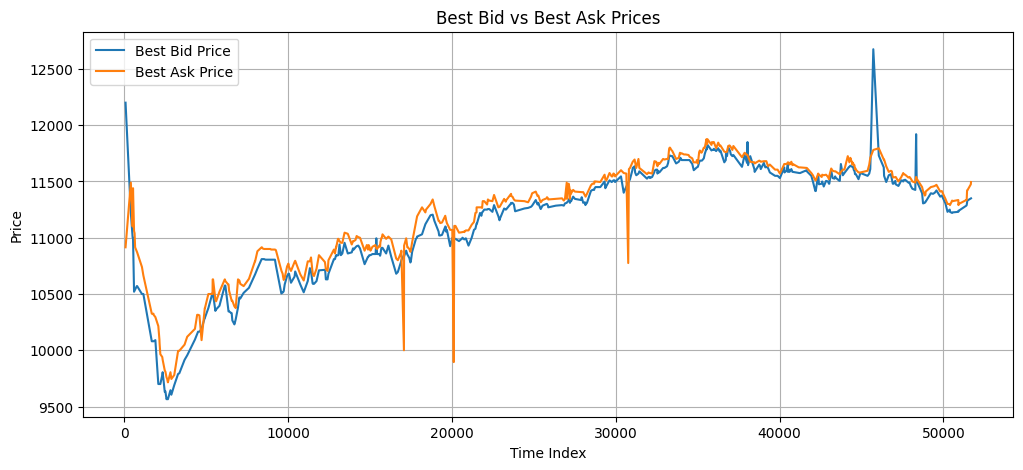

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['BidPrice1'][:500], label="Best Bid Price")
plt.plot(df['AskPrice1'][:500], label="Best Ask Price")
plt.title("Best Bid vs Best Ask Prices")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


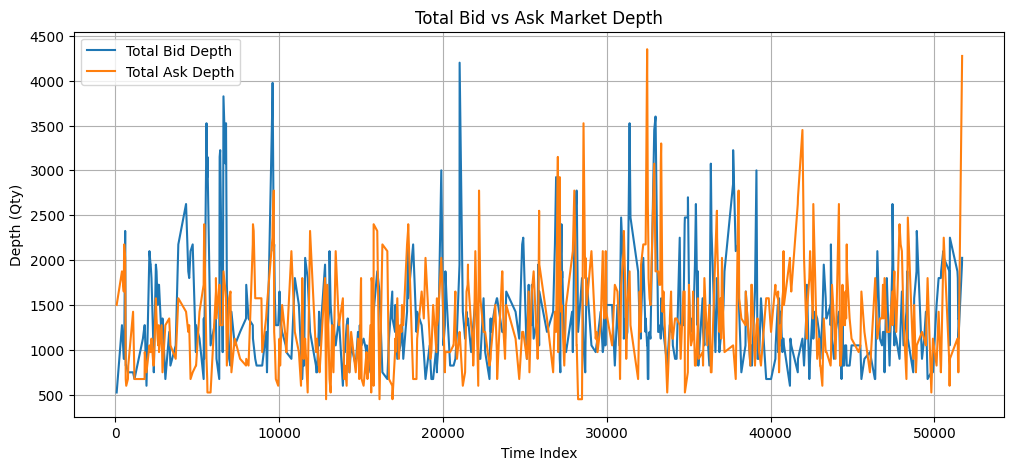

In [ ]:
df['TotalBidDepth'] = df[['BidQty1','BidQty2','BidQty3','BidQty4','BidQty5']].sum(axis=1)
df['TotalAskDepth'] = df[['AskQty1','AskQty2','AskQty3','AskQty4','AskQty5']].sum(axis=1)

plt.figure(figsize=(12,5))
plt.plot(df['TotalBidDepth'][:500], label="Total Bid Depth")
plt.plot(df['TotalAskDepth'][:500], label="Total Ask Depth")
plt.title("Total Bid vs Ask Market Depth")
plt.xlabel("Time Index")
plt.ylabel("Depth (Qty)")
plt.legend()
plt.grid(True)
plt.show()


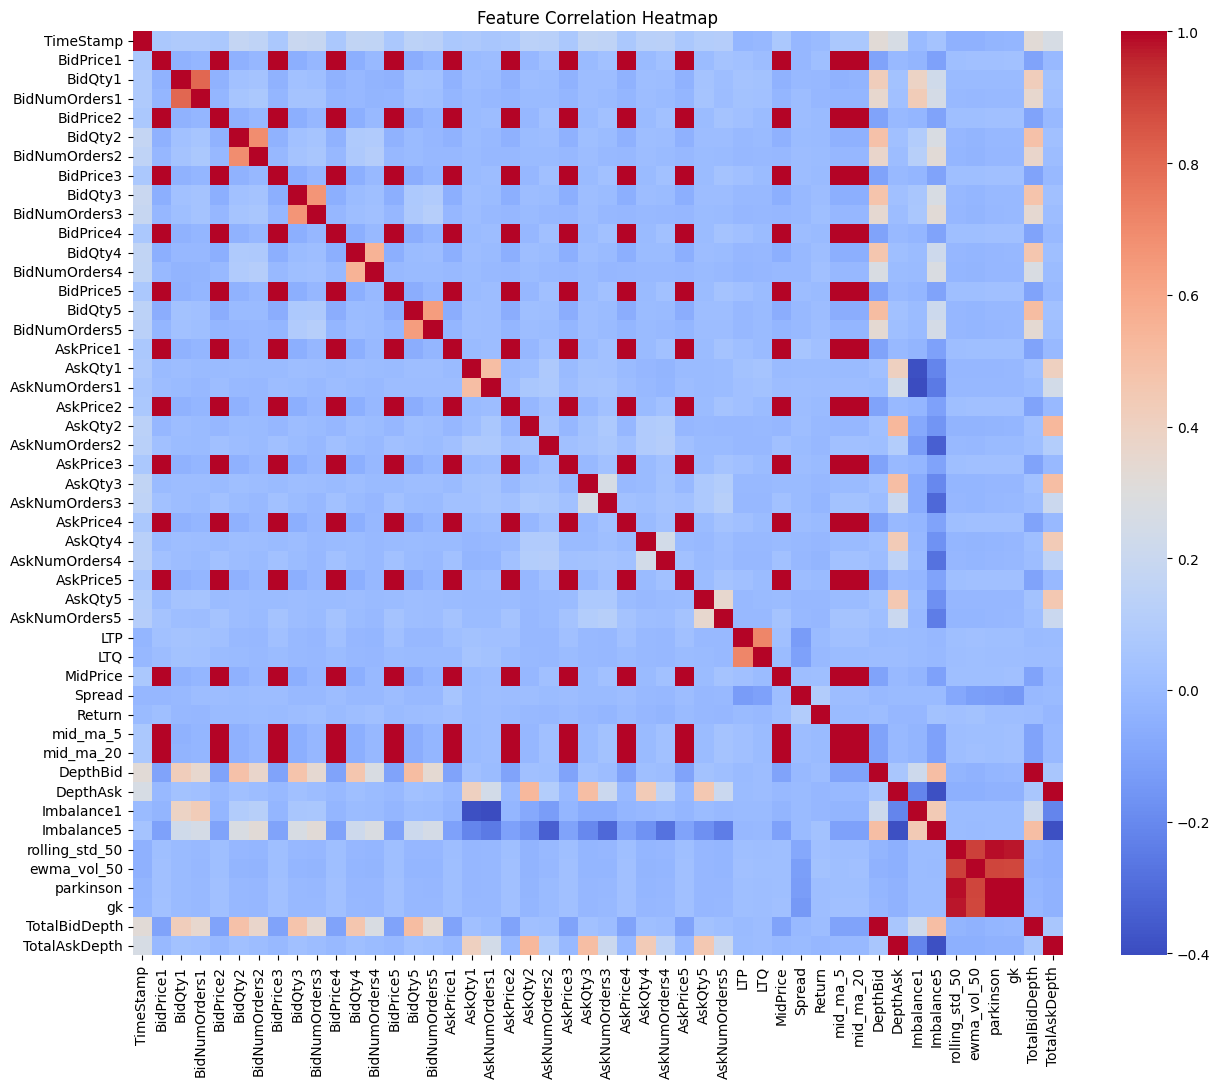

In [ ]:
import seaborn as sns
plt.figure(figsize=(15,12))
sns.heatmap(df.corr(), cmap="coolwarm", annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()


In [ ]:
df.columns

Index(['TimeStamp', 'BidPrice1', 'BidQty1', 'BidNumOrders1', 'BidPrice2',
       'BidQty2', 'BidNumOrders2', 'BidPrice3', 'BidQty3', 'BidNumOrders3',
       'BidPrice4', 'BidQty4', 'BidNumOrders4', 'BidPrice5', 'BidQty5',
       'BidNumOrders5', 'AskPrice1', 'AskQty1', 'AskNumOrders1', 'AskPrice2',
       'AskQty2', 'AskNumOrders2', 'AskPrice3', 'AskQty3', 'AskNumOrders3',
       'AskPrice4', 'AskQty4', 'AskNumOrders4', 'AskPrice5', 'AskQty5',
       'AskNumOrders5', 'LTP', 'LTQ', 'MidPrice', 'Spread', 'Return',
       'mid_ma_5', 'mid_ma_20', 'DepthBid', 'DepthAsk', 'Imbalance1',
       'Imbalance5', 'rolling_std_50', 'ewma_vol_50', 'parkinson', 'gk'],
      dtype='object')

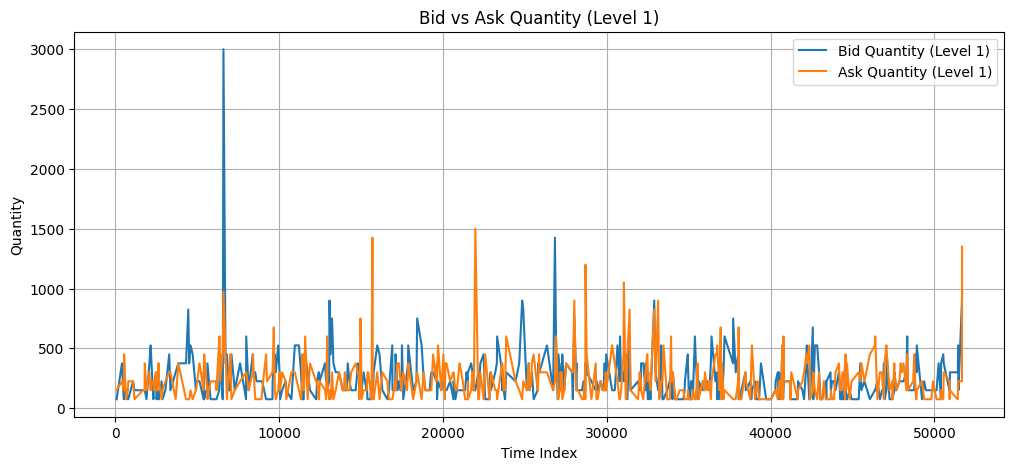

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['BidQty1'][:500], label="Bid Quantity (Level 1)")
plt.plot(df['AskQty1'][:500], label="Ask Quantity (Level 1)")
plt.title("Bid vs Ask Quantity (Level 1)")
plt.xlabel("Time Index")
plt.ylabel("Quantity")
plt.legend()
plt.grid(True)
plt.show()


**Feature engineering**

In [ ]:
columns_to_drop = [
    "BidPrice4","BidQty4","BidNumOrders4",
    "BidPrice5","BidQty5","BidNumOrders5",
    "AskPrice4","AskQty4","AskNumOrders4",
    "AskPrice5","AskQty5","AskNumOrders5",

    "BidNumOrders2","BidNumOrders3","BidNumOrders5",
    "AskNumOrders2","AskNumOrders3","AskNumOrders5",

    "LTP","LTQ"
]

df = df.drop(columns=[c for c in columns_to_drop if c in df.columns],
             errors='ignore')


In [ ]:
df = df.dropna().reset_index(drop=True)


In [ ]:
df.columns

Index(['TimeStamp', 'BidPrice1', 'BidQty1', 'BidNumOrders1', 'BidPrice2',
       'BidQty2', 'BidPrice3', 'BidQty3', 'AskPrice1', 'AskQty1',
       'AskNumOrders1', 'AskPrice2', 'AskQty2', 'AskPrice3', 'AskQty3',
       'MidPrice', 'Spread', 'Return', 'mid_ma_5', 'mid_ma_20', 'DepthBid',
       'DepthAsk', 'Imbalance1', 'Imbalance5', 'rolling_std_50', 'ewma_vol_50',
       'parkinson', 'gk'],
      dtype='object')

In [ ]:
# List of final features you confirmed
feature_columns = [
    'BidPrice1','BidQty1','BidNumOrders1',
    'BidPrice2','BidQty2',
    'BidPrice3','BidQty3',

    'AskPrice1','AskQty1','AskNumOrders1',
    'AskPrice2','AskQty2',
    'AskPrice3','AskQty3',

    'MidPrice', 'Spread', 'Return',
    'mid_ma_5', 'mid_ma_20',
    'DepthBid', 'DepthAsk',
    'Imbalance1', 'Imbalance5',
    'rolling_std_50', 'ewma_vol_50',
    'parkinson', 'gk'
]


df['target'] = df['MidPrice'].shift(-1)
df = df.dropna().reset_index(drop=True)

X = df[feature_columns]
y = df['target']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


**Model Building**

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.05,
    'verbose': -1
}

train_set = lgb.Dataset(X_train, y_train)
val_set = lgb.Dataset(X_test, y_test)

model = lgb.train(
    params,
    train_set,
    valid_sets=[train_set, val_set],
    num_boost_round=200,
    callbacks=[
        lgb.log_evaluation(period=20)
    ]
)





[20]	training's rmse: 432.471	valid_1's rmse: 247.248
[40]	training's rmse: 159.453	valid_1's rmse: 96.6492
[60]	training's rmse: 67.7393	valid_1's rmse: 52.2481
[80]	training's rmse: 43.0534	valid_1's rmse: 43.4865
[100]	training's rmse: 38.077	valid_1's rmse: 42.289
[120]	training's rmse: 36.7059	valid_1's rmse: 42.1407
[140]	training's rmse: 35.8905	valid_1's rmse: 42.1421
[160]	training's rmse: 35.2476	valid_1's rmse: 42.152
[180]	training's rmse: 34.7302	valid_1's rmse: 42.1747
[200]	training's rmse: 34.3363	valid_1's rmse: 42.2011


In [ ]:
y_pred = model.predict(X_test)


In [ ]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("RMSE:", rmse)
print("MAE:", mae)


RMSE: 42.20110241927637
MAE: 10.52635020657492


**Model evaluation**

In [ ]:
actual_dir = (y_test.diff() > 0).astype(int)
pred_dir = (pd.Series(y_pred).diff() > 0).astype(int)

directional_accuracy = accuracy_score(actual_dir[1:], pred_dir[1:])
print("Directional Accuracy:", directional_accuracy)


Directional Accuracy: 0.5441419762370281


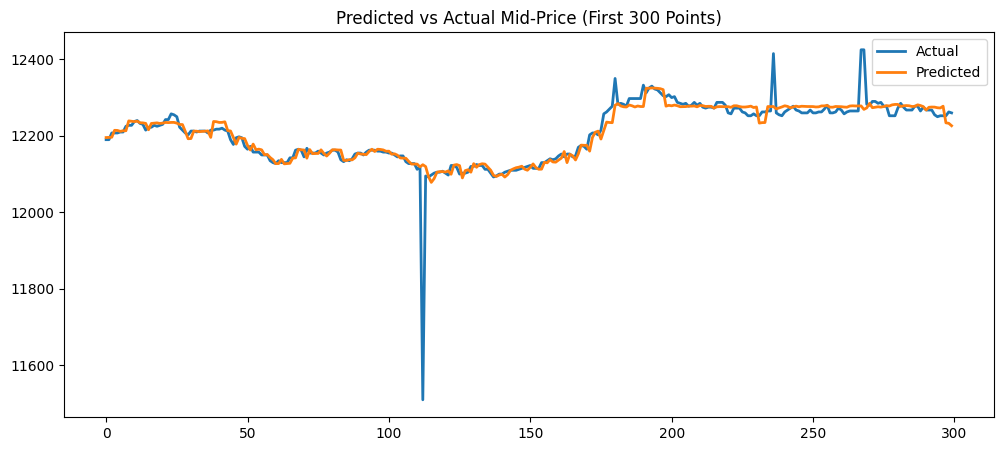

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:300], label="Actual", linewidth=2)
plt.plot(y_pred[:300], label="Predicted", linewidth=2)
plt.legend()
plt.title("Predicted vs Actual Mid-Price (First 300 Points)")
plt.show()


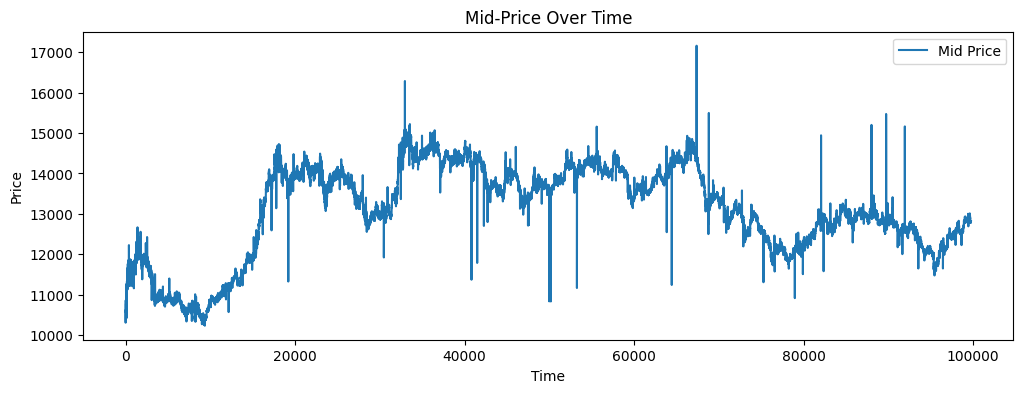

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df["MidPrice"], label="Mid Price")
plt.title("Mid-Price Over Time")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()


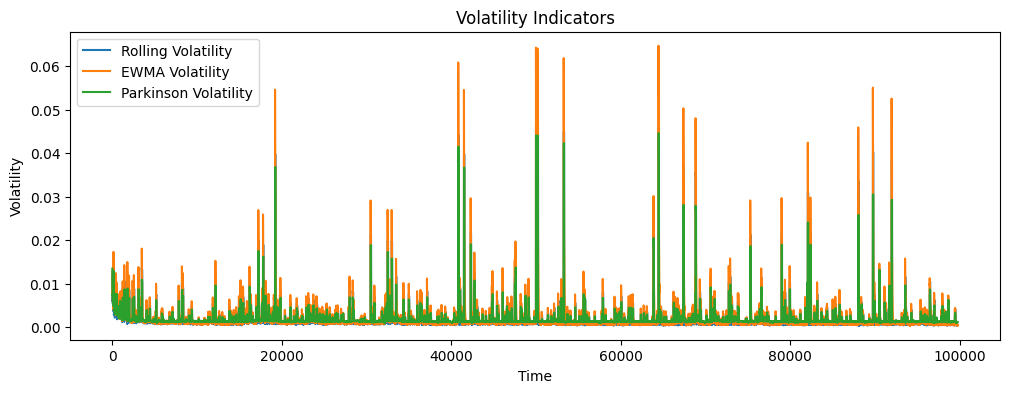

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df["rolling_std_50"], label="Rolling Volatility")
plt.plot(df["ewma_vol_50"], label="EWMA Volatility")
plt.plot(df["parkinson"], label="Parkinson Volatility")
plt.title("Volatility Indicators")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.legend()
plt.show()


In [ ]:
df.columns

Index(['TimeStamp', 'BidPrice1', 'BidQty1', 'BidNumOrders1', 'BidPrice2',
       'BidQty2', 'BidPrice3', 'BidQty3', 'AskPrice1', 'AskQty1',
       'AskNumOrders1', 'AskPrice2', 'AskQty2', 'AskPrice3', 'AskQty3',
       'MidPrice', 'Spread', 'Return', 'mid_ma_5', 'mid_ma_20', 'DepthBid',
       'DepthAsk', 'Imbalance1', 'Imbalance5', 'rolling_std_50', 'ewma_vol_50',
       'parkinson', 'gk', 'target'],
      dtype='object')

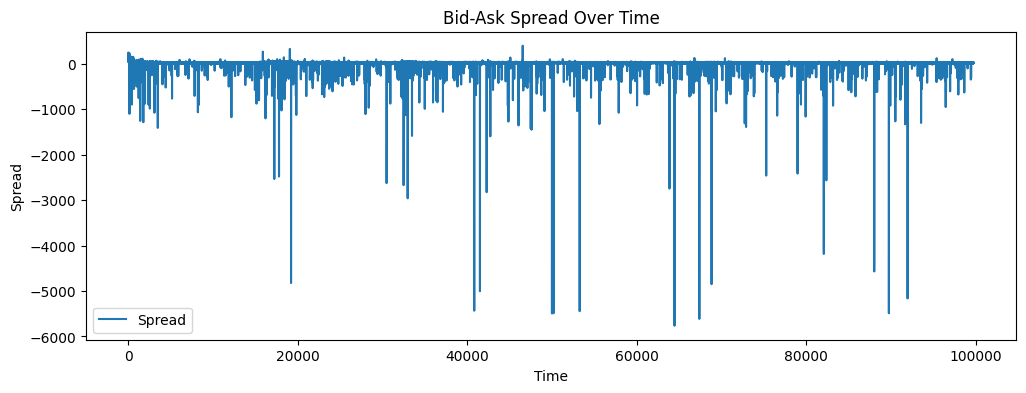

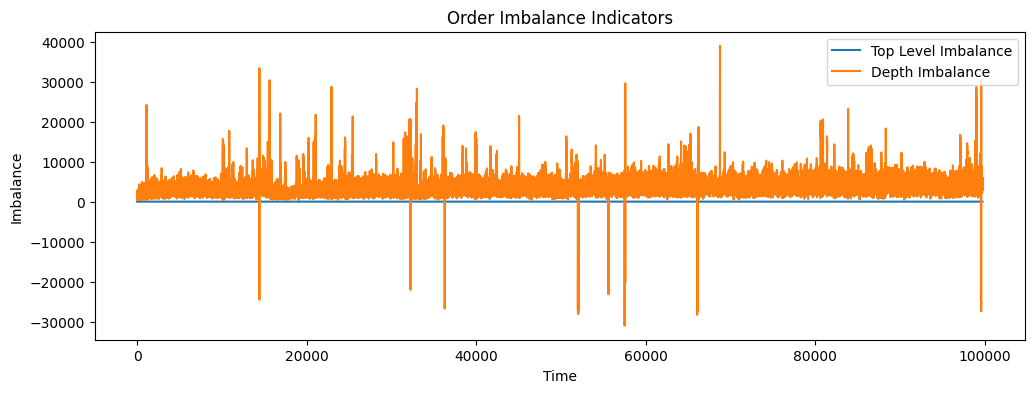

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(df["Spread"], label="Spread")
plt.title("Bid-Ask Spread Over Time")
plt.xlabel("Time")
plt.ylabel("Spread")
plt.legend()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df["Imbalance1"], label="Top Level Imbalance")
plt.plot(df["DepthAsk"], label="Depth Imbalance")
plt.title("Order Imbalance Indicators")
plt.xlabel("Time")
plt.ylabel("Imbalance")
plt.legend()
plt.show()
